## Set up workspace

In [5]:
import pandas as pd
import numpy as np
import json
import requests
import matplotlib.pyplot as plt

## Extract data from World Bank API

### Extract target indicator data

In [6]:
# Read People using at least basic sanitation services (% of population) from World Bank API

# Declares the base URL for calling API
wb_base_url = 'http://api.worldbank.org/v2/'
# Set the code for the desired indicator
indicator_code_wb = 'SH.STA.BASS.ZS'
# Define the target url
target = wb_base_url + f'country/indicator/{indicator_code_wb}?format=json' 

# Initial data query
response_i = requests.get(target)
j_i = response_i.json()

# Total pages and records
total_pages = j_i[0]['pages']
total_records = j_i[0]['total']
print(f'Total pages: {total_pages}')
print(f'Total records: {total_records}')

# Create dataframe from the first page of the response
sanitation_raw = pd.json_normalize(j_i[1])
# loop through the pages in the response and append to dataframe
for page in range(2, total_pages+1):
    target = wb_base_url + f'country/indicator/{indicator_code_wb}?&page={page}&format=json'
    response = requests.get(target)
    j = response.json()
    df_temp = pd.json_normalize(j[1])
    sanitation_raw = pd.concat([sanitation_raw, df_temp], ignore_index = True)

# Verify that the number of rows in the dataframe is equal to the total number of records returned from the API call
assert len(sanitation_raw) == total_records, 'DataFrame observations do not match total number of records in response'

print(sanitation_raw.dtypes)
print(sanitation_raw.head())

Total pages: 336
Total records: 16758


C:\Users\lxtgu\AppData\Local\Temp\ipykernel_8316\2544371760.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sanitation_raw = pd.concat([sanitation_raw, df_temp], ignore_index = True)


countryiso3code     object
date                object
value              float64
unit                object
obs_status          object
decimal              int64
indicator.id        object
indicator.value     object
country.id          object
country.value       object
dtype: object
  countryiso3code  date      value unit obs_status  decimal    indicator.id  \
0             AFE  2022  31.746333                        0  SH.STA.BASS.ZS   
1             AFE  2021  31.501568                        0  SH.STA.BASS.ZS   
2             AFE  2020  31.548450                        0  SH.STA.BASS.ZS   
3             AFE  2019  31.158408                        0  SH.STA.BASS.ZS   
4             AFE  2018  30.730436                        0  SH.STA.BASS.ZS   

                                     indicator.value country.id  \
0  People using at least basic sanitation service...         ZH   
1  People using at least basic sanitation service...         ZH   
2  People using at least basic sanitatio

In [7]:
# Check the values in info columns
print(sanitation_raw['unit'].unique())
print(sanitation_raw['obs_status'].unique())
print(sanitation_raw['decimal'].unique())

['']
['']
[0]


### Extract income group data

In [8]:
# Read Income Group Metadata from World Bank Open Data API
target = wb_base_url + f'sources/2/country/all/metatypes/incomegroup/metadata?format=json'

# Data query
response = requests.get(target)
j = response.json()

# Total pages and records
total_pages = j['pages']
total_records = j['total']
print(f'Total pages: {total_pages}')
print(f'Total records: {total_records}')

# Create dataframe for the results
income_group = pd.json_normalize(j['source'])
income_group = pd.json_normalize(income_group['concept'].explode(), 'variable').reset_index()
income_group_metatype = pd.json_normalize(income_group['metatype'].explode()).reset_index().drop(columns=['id'])
income_group = pd.merge(income_group, income_group_metatype, on = 'index', how = 'left').drop(columns=['index', 'metatype'])
income_group.columns = ['iso', 'income_group']

print(income_group.head())


Total pages: 1
Total records: 217
   iso         income_group
0  ABW          High income
1  AFG           Low income
2  AGO  Lower middle income
3  ALB  Upper middle income
4  AND          High income


### Create tables for analysis

In [9]:
# Create final dataframe for analysis
sanitation = pd.merge(sanitation_raw, income_group, left_on = 'countryiso3code', right_on = 'iso', how = 'left')\
    .drop(columns = ['iso', 'indicator.id', 'indicator.value', 'country.id', 'unit', 'obs_status', 'decimal'])

# Drop the rows with date before 2000 since there is no value
sanitation = sanitation[sanitation['date'] > '1999']

# Subset the rows with null values in income_group
sanitation_by_country = sanitation[sanitation['income_group'].notnull()]
sanitation_group = sanitation[sanitation['income_group'].isnull()]

## Data quality check and analysis

### Group level

In [10]:
# Understand what's in the WB pre processed group
sanitation_group['country.value'].unique()

array(['Africa Eastern and Southern', 'Africa Western and Central',
       'Arab World', 'Caribbean small states',
       'Central Europe and the Baltics', 'Early-demographic dividend',
       'East Asia & Pacific',
       'East Asia & Pacific (excluding high income)',
       'East Asia & Pacific (IDA & IBRD countries)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)',
       'Europe & Central Asia (IDA & IBRD countries)', 'European Union',
       'Fragile and conflict affected situations',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only',
       'IDA total', 'Late-demographic dividend',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Latin America & the Caribbean (IDA & IBRD countries)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle in

In [11]:
# Create a dataframe only with income groups and the whole world
sanitation_by_group = sanitation_group[sanitation_group['country.value'].isin(['World', 'Low income', 'Upper middle income', 'Lower middle income', 'High income'])]
sanitation_by_group = sanitation_by_group.drop(columns = ['countryiso3code', 'income_group'])

print(sanitation_by_group.head())

      date      value country.value
1008  2022  99.015962   High income
1009  2021  99.000315   High income
1010  2020  98.987898   High income
1011  2019  98.972901   High income
1012  2018  98.961888   High income


In [12]:
# Pivot the dataframe for visualization
sanitation_by_group_piv = sanitation_by_group.pivot(index = 'date', columns = 'country.value', values = 'value')
sanitation_by_group_piv.reset_index(inplace = True)

# Drop the rows with null values in World column
sanitation_by_group_piv = sanitation_by_group_piv[sanitation_by_group_piv['World'].notnull()]

print(sanitation_by_group_piv.head())

country.value  date  High income  Low income  Lower middle income  \
0              2000    98.612538   19.478754            31.601490   
1              2001    98.159303   19.685667            33.259077   
2              2002    98.212602   23.284043            35.054560   
3              2003    98.259327   23.541664            36.867560   
4              2004    98.305078   23.819266            38.702181   

country.value  Upper middle income      World  
0                        63.823217  55.396973  
1                        64.602783  56.262797  
2                        66.146717  57.478686  
3                        67.680326  58.632754  
4                        69.204377  59.798105  


#### Exploratory visualization

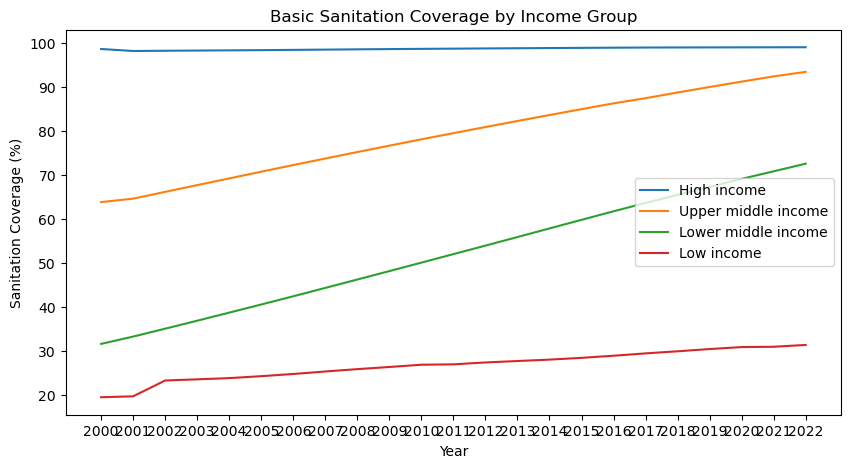

In [13]:
# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(sanitation_by_group_piv['date'], sanitation_by_group_piv['High income'], label = 'High income')
plt.plot(sanitation_by_group_piv['date'], sanitation_by_group_piv['Upper middle income'], label = 'Upper middle income')
plt.plot(sanitation_by_group_piv['date'], sanitation_by_group_piv['Lower middle income'], label = 'Lower middle income')
plt.plot(sanitation_by_group_piv['date'], sanitation_by_group_piv['Low income'], label = 'Low income')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Sanitation Coverage (%)')
plt.title('Basic Sanitation Coverage by Income Group')
plt.show()

### Country level

In [14]:
# The total number of countries
print(f"Total number of countries: {len(sanitation_by_country['country.value'].unique())}")

# Verify that the number of countries in the final df is equal to the total number of countries in the income group
print(True if len(sanitation_by_country['country.value'].unique()) == len(income_group['iso'].unique()) else False)

Total number of countries: 216
False


In [15]:
# Check which countries are missing in the sanitation dataset
income_group[~income_group['iso'].isin(sanitation_by_country['countryiso3code'])]

,iso,income_group
199,TWN,High income


In [16]:
# The number of countries in each income group
print(sanitation_by_country.groupby('income_group')['country.value'].nunique())

income_group
High income            82
Low income             26
Lower middle income    54
Upper middle income    54
Name: country.value, dtype: int64


In [17]:
# The simple average of sanitation coverage by income group by year
sanitation_by_country_agg = pd.DataFrame(sanitation_by_country.groupby(['income_group', 'date'])['value'].mean())
sanitation_by_country_agg_piv = sanitation_by_country_agg.pivot_table(index = 'date', columns = 'income_group', values = 'value').reset_index()

print(sanitation_by_country_agg_piv.head())

income_group  date  High income  Low income  Lower middle income  \
0             2000    95.108947   21.088457            43.816070   
1             2001    94.785778   21.381693            44.688262   
2             2002    94.892968   23.902827            45.478129   
3             2003    94.995996   24.289657            46.494178   
4             2004    95.099436   24.700376            47.526050   

income_group  Upper middle income  
0                       77.580191  
1                       78.234106  
2                       78.771989  
3                       79.324126  
4                       79.896528  


#### Exploratory visualization

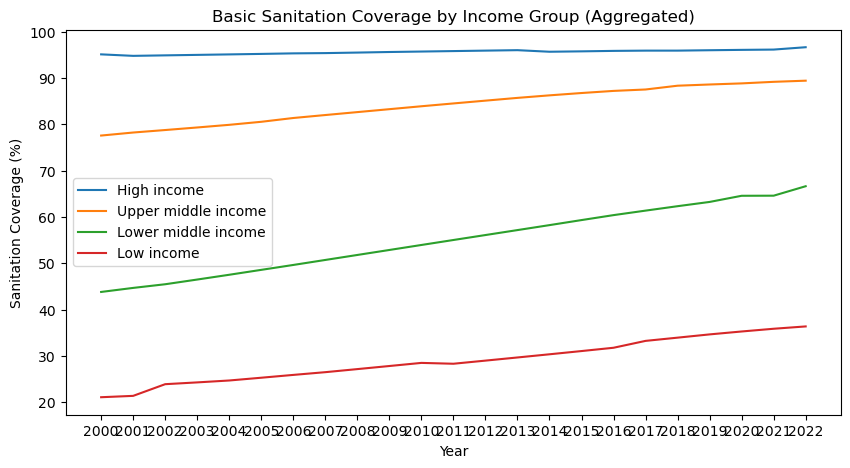

In [18]:
# Plot the income group sanitation coverage calculated by simple average
plt.figure(figsize=(10, 5))
plt.plot(sanitation_by_country_agg_piv['date'], sanitation_by_country_agg_piv['High income'], label = 'High income')
plt.plot(sanitation_by_country_agg_piv['date'], sanitation_by_country_agg_piv['Upper middle income'], label = 'Upper middle income')
plt.plot(sanitation_by_country_agg_piv['date'], sanitation_by_country_agg_piv['Lower middle income'], label = 'Lower middle income')
plt.plot(sanitation_by_country_agg_piv['date'], sanitation_by_country_agg_piv['Low income'], label = 'Low income')

plt.legend()
plt.xlabel('Year')
plt.ylabel('Sanitation Coverage (%)')
plt.title('Basic Sanitation Coverage by Income Group (Aggregated)')
plt.show()

###### Note: Both versions of income group data (pre-processed in WB data vs. aggregated based on country data) show a consistent increase in sanitation coverage across all income groups from 2000 to 2022. However, the version based on aggregated country data shows a faster increasing trend compared to the pre-processed version. This difference might be attributed to two factors: 1) The WB pre-aggregated the data using a weighted average, while I used a simple average due to a lack of information on the appropriate weighting criteria; 2) The WB pre-processed the data by excluding entries based on a small sample, as indicated in the dataset metadata: "...regional and income group estimates are made when data are available for at least 50 percent of the population."

## Final Visualization (Using the WB pre-processed income group data)

C:\Users\lxtgu\AppData\Local\Temp\ipykernel_8316\321894799.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{int(round(y, 0))}%' for y in ax.get_yticks()])


Text(-2.7940000000000005, 6.75280113422116, 'Source: WHO/UNICEF Joint Monitoring Programme (JMP) for Water Supply, Sanitation and Hygiene')

c:\Users\lxtgu\anaconda3\envs\wbds\Lib\site-packages\matplotlib\text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


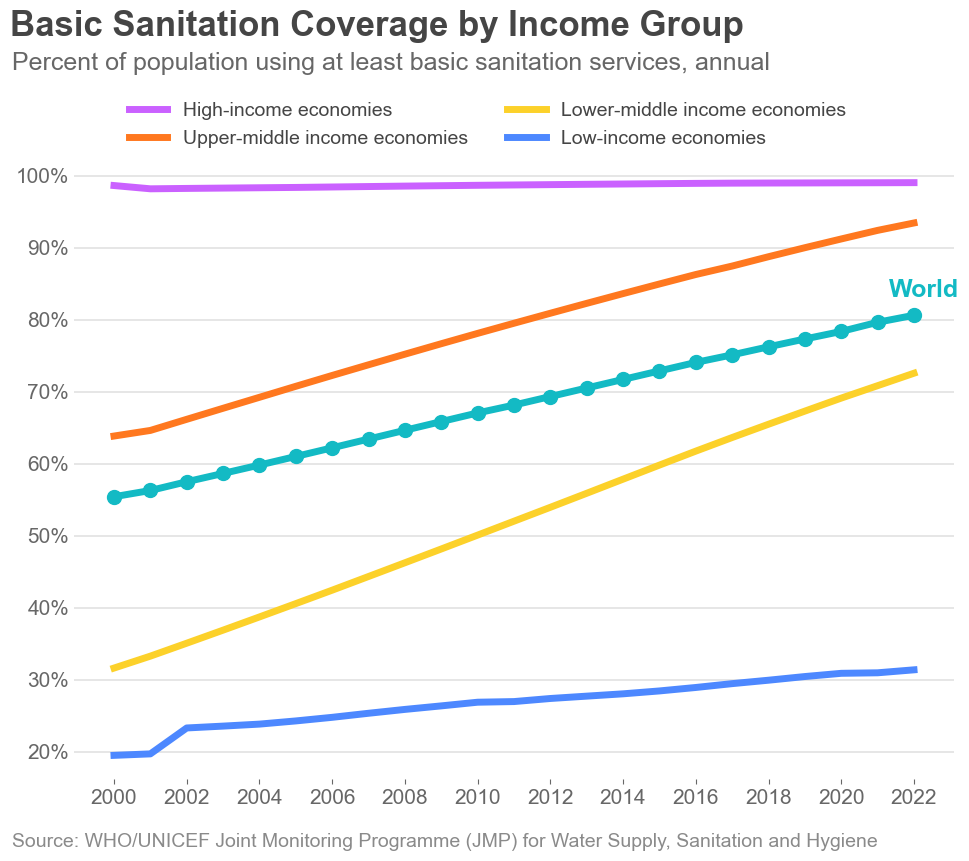

In [19]:
# Set font style and chart size
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (16, 9))
plt.subplots_adjust(left = 0.15, right = 0.7, top = 0.8, bottom = 0.1)

# Plot a line chart
ax.plot(sanitation_by_group_piv['date'], sanitation_by_group_piv['High income'], '-', color = '#CA61FF', linewidth = 5, label = 'High-income economies')
ax.plot(sanitation_by_group_piv['date'], sanitation_by_group_piv['Upper middle income'], '-', color = '#FF781F', linewidth = 5, label = 'Upper-middle income economies')
ax.plot(sanitation_by_group_piv['date'], sanitation_by_group_piv['Lower middle income'], '-', color = '#FCD12A', linewidth = 5, label = 'Lower-middle income economies')
ax.plot(sanitation_by_group_piv['date'], sanitation_by_group_piv['Low income'], '-', color = '#4D88FF', linewidth = 5, label = 'Low-income economies')
ax.plot(sanitation_by_group_piv['date'], sanitation_by_group_piv['World'], '-', color = '#13BAC4', linewidth = 5, marker = 'o', markersize = 10)

# Add annotations for World
ax.annotate(xy = (sanitation_by_group_piv['date'][-1:], sanitation_by_group_piv['World'][-1:]), \
                xytext = (-18,18), textcoords = 'offset points', text = 'World', va = 'center', size = 18, weight = 'bold', color = '#13BAC4')

### Format Plot

# Add major grid lines
ax.grid(which = 'major', axis = 'y', color = '#8A8A8A', lw = 0.3)

# Remove borders
ax.spines[:].set_visible(False)

# Set parameters for tick labels and remove ticks
ax.tick_params(axis = 'both', labelsize = 15, colors = '#676767', direction = 'in', bottom = True, left = False) 

# Set X interval
ax.set_xticks(sanitation_by_group_piv['date'][::2])

# Set Y labels
ax.set_yticklabels([f'{int(round(y, 0))}%' for y in ax.get_yticks()])

bott, top = plt.ylim()
left, right = plt.xlim()

# Set title and subtitle
plt.suptitle('Basic Sanitation Coverage by Income Group', \
             x = 0.11, y = 0.96, fontsize = 25, fontweight = 'bold', color = '#454545', horizontalalignment = 'left')
plt.title('Percent of population using at least basic sanitation services, annual', \
          x = -0.07, y = 1.12, fontsize = 18, color = '#676767', horizontalalignment = 'left')

# Set legend
leg = ax.legend(frameon = False, loc = 'upper center', bbox_to_anchor = (0.47,1.11), ncol = 2, fontsize = 14)
plt.setp(leg.get_texts(), color = '#454545')

# Set source
ax.text(left-0.07*(right-left), bott-0.1*(top-bott), \
        s = "Source: WHO/UNICEF Joint Monitoring Programme (JMP) for Water Supply, Sanitation and Hygiene", \
            color = '#8A8A8A', fontsize = 14)